<a href="https://colab.research.google.com/github/icekang/NLP_2021/blob/main/hw8_key_value_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Key-Value Attention Mechanism Homework on Keras: Character-level Machine Translation (Many-to-Many, encoder-decoder)

In this homework, you will create an MT model with key-value attention mechnism that coverts names of constituency MP candidates in the 2019 Thai general election from Thai script to Roman(Latin) script. E.g. นิยม-->niyom 

In [3]:
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
mpl.rc('font', family='TH Sarabun New')

--2021-03-21 15:08:50--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2021-03-21 15:08:51--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: ‘thsarabunnew-webfont.ttf’

thsarabunnew-webfon 100%[===================>]  96.00K  --.-KB/s    in 0.005s  

2021-03-21 15:08:51 (18.7 MB/s) - ‘t

In [4]:
%matplotlib inline
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import numpy as np

import random

## Load Dataset
We have generated a toy dataset using names of constituency MP candidates in 2019 Thai General Election from elect.in.th's github(https://github.com/codeforthailand/dataset-election-62-candidates) and tltk (https://pypi.org/project/tltk/) library to convert them into Roman script.

<img src="https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/images/dataset_diagram.png" alt="Drawing" style="width: 500px;"/>


In [5]:
!wget https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv

--2021-03-21 15:08:52--  https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324399 (317K) [text/plain]
Saving to: ‘mp_name_th_en.csv’

mp_name_th_en.csv   100%[===================>] 316.80K  --.-KB/s    in 0.02s   

2021-03-21 15:08:52 (19.2 MB/s) - ‘mp_name_th_en.csv’ saved [324399/324399]



In [6]:
import csv
with open('mp_name_th_en.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    name_th = []
    name_en = []
    for row in readCSV:
        name_th.append(row[0])
        name_en.append(row[1])

In [7]:
for th, en in zip(name_th[:10],name_en[:10]):
    print(th,en)

ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak


## Task1: Preprocess dataset for Keras (1 point)
* 2 dictionaries for indexing (1 for input and another for output)
* DON'T FORGET TO INCLUDE special token for padding
* DON'T FORGET TO INCLUDE special token for the end of word symbol (output)
* Be mindful of your pad_sequences "padding" hyperparameter. Choose wisely (post-padding vs pre-padding)

In [8]:
#FILL YOUR CODE HERE

#Preprocessing
input_chars = list(set(''.join(name_th)))
output_chars = list(set(''.join(name_en)))

# +1 for padding
data_size, vocab_size = len(name_th), len(input_chars)+1 
output_vocab_size = len(output_chars)+1

print('There are %d lines and %d unique characters in your input data.' % (data_size, vocab_size))
maxlen = len(max(name_th, key=len)) #max input length

output_maxlen = len(max(name_en, key=len)) #max input length

print("Max input length:", maxlen)

sorted_chars= sorted(input_chars)
sorted_output_chars= sorted(output_chars)
sorted_chars.insert(0,"<PAD>") #PADDING for input
sorted_output_chars.insert(0,"<PAD>") #PADDING for output
#Input
char_to_ix = { ch:i for i,ch in enumerate(sorted_chars) }
ix_to_char = { i:ch for i,ch in enumerate(sorted_chars) } #reverse dictionary
#Output
output_char_to_ix = { ch:i for i,ch in enumerate(sorted_output_chars) }
ix_to_output_char = { i:ch for i,ch in enumerate(sorted_output_chars) } #reverse dictionary

print(ix_to_char)

m=data_size
Tx=maxlen
Ty=output_maxlen

X = []
for line in name_th:
    temp=[]
    for char in line:
        temp.append(char_to_ix[char])
    X.append(temp)
Y = []
for line in name_en:
    temp=[]
    for char in line:
        temp.append(output_char_to_ix[char])
    Y.append(temp)    

X = pad_sequences(X,maxlen=maxlen)
Y = pad_sequences(Y,maxlen=output_maxlen)

X= to_categorical(X,vocab_size)
X=X.reshape(data_size,maxlen ,vocab_size)

Y= to_categorical(Y,output_vocab_size)
Y=Y.reshape(data_size,output_maxlen,output_vocab_size)
print(X.shape,Y.shape)

There are 10887 lines and 65 unique characters in your input data.
Max input length: 20
{0: '<PAD>', 1: ' ', 2: 'ก', 3: 'ข', 4: 'ค', 5: 'ฆ', 6: 'ง', 7: 'จ', 8: 'ฉ', 9: 'ช', 10: 'ซ', 11: 'ฌ', 12: 'ญ', 13: 'ฎ', 14: 'ฏ', 15: 'ฐ', 16: 'ฑ', 17: 'ฒ', 18: 'ณ', 19: 'ด', 20: 'ต', 21: 'ถ', 22: 'ท', 23: 'ธ', 24: 'น', 25: 'บ', 26: 'ป', 27: 'ผ', 28: 'ฝ', 29: 'พ', 30: 'ฟ', 31: 'ภ', 32: 'ม', 33: 'ย', 34: 'ร', 35: 'ล', 36: 'ว', 37: 'ศ', 38: 'ษ', 39: 'ส', 40: 'ห', 41: 'ฬ', 42: 'อ', 43: 'ฮ', 44: 'ะ', 45: 'ั', 46: 'า', 47: 'ำ', 48: 'ิ', 49: 'ี', 50: 'ึ', 51: 'ื', 52: 'ุ', 53: 'ู', 54: 'เ', 55: 'แ', 56: 'โ', 57: 'ใ', 58: 'ไ', 59: '็', 60: '่', 61: '้', 62: '๊', 63: '๋', 64: '์'}
(10887, 20, 65) (10887, 19, 23)


# Attention Mechanism
## Task 2: Code your own (key-value) attention mechnism (1 point)
* PLEASE READ: you DO NOT have to follow all the details in (Daniluk, et al. 2017). You just need to create a key-value attention mechanism where the "key" part of the mechanism is used for attention score calculation, and the "value" part of the mechanism is used to encode information to create a context vector.  
* Define global variables
* fill code for one_step_attention function
* Hint: use keras.layers.Lambda 
* HINT: you will probably need more hidden dimmensions than what you've seen in the demo


In [9]:
from tensorflow.keras.activations import softmax
from tensorflow.keras.layers import Lambda
def softMaxAxis1(x):
    return softmax(x,axis=1)


In [10]:
#These are global variables (shared layers)
## Fill your code here
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
#Attention function###
fattn_1 = Dense(10, activation = "tanh", name='fattn_1')
fattn_2 = Dense(1, activation = "relu", name='fattn_2')
###
activator = Activation(softMaxAxis1, name='attention_scores') 
dotor = Dot(axes = 1)
## you are allowed to use code in the demo as your template.  

In [11]:
n_h = 128 #hidden dimensions for encoder 
n_s = 256 #hidden dimensions for decoder

In [12]:
def one_step_attention(a, s_prev):

    #Fill code here
    a_key = Lambda(lambda x: x[:,:,:n_h])(a)
    a_val = Lambda(lambda x: x[:,:,n_h:])(a)
    # Repeat the decoder hidden state to concat with encoder hidden states
    s_prev = repeator(s_prev)
    concat = concatenator([a_key,s_prev])
    # attention function
    e = fattn_1(concat)
    energies =fattn_2(e) # (None, 1)
    # calculate attention_scores (softmax)
    attention_scores = activator(energies) #(None, 1)
    #calculate a context vector
    context = dotor([attention_scores,a_val])

    return context # return whatever you need to complete this homework 

## Task3: Create and train your encoder/decoder model here (1 point)
* HINT: you will probably need more hidden dimmensions than what you've seen in the demo

In [13]:
#FILL CODE HERE
encoder_LSTM =  Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(-1, Tx, n_h*2), name='encoder')
decoder_LSTM_cell = LSTM(n_s, return_state = True, name='decoder') #decoder_LSTM_cell
output_layer = Dense(output_vocab_size, activation="softmax") #softmax output layer

In [14]:
#FIT YOUR MODEL HERE
def model(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_h -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    vocab_size -- size of the input vocab
    output_vocab_size -- size of the output vocab

    Returns:
    model -- Keras model instance
    """
    
    # Define the input of your model
    X = Input(shape=(Tx, vocab_size), name='input_name')
    # Define hidden state and cell state for decoder_LSTM_Cell
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = list()

    #Encoder Bi-LSTM
    # h = Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(-1, Tx, n_h*2))(X)
    h = encoder_LSTM(X)
    #Iterate for Ty steps (Decoding)
    for t in range(Ty):
    
        #Perform one step of the attention mechanism to calculate the context vector at timestep t
        context = one_step_attention(h, s)
        # Feed the context vector to the decoder LSTM cell
        s, _, c = decoder_LSTM_cell(context,initial_state=[s,c])

        # Pass the decoder hidden output to the output layer (softmax)
        out = output_layer(s)
        
        # Append an output list with the current output
        outputs.append(out)
    
    #Create model instance
    model = Model(inputs=[X,s0,c0],outputs=outputs)
    
    return model

In [15]:
model = model(Tx, Ty, n_h, n_s, vocab_size, output_vocab_size)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_name (InputLayer)         [(None, 20, 65)]     0                                            
__________________________________________________________________________________________________
encoder (Bidirectional)         (None, 20, 256)      198656      input_name[0][0]                 
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 256)]        0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 20, 128)      0           encoder[0][0]                    
______________________________________________________________________________________________

In [17]:
opt = Adam(lr= 0.01, clipvalue=0.5)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [18]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Y.swapaxes(0,1))

In [19]:
model.fit([X, s0, c0], outputs, epochs=20, batch_size=128)

Epoch 1/20
86/86 [==============================] - 53s 71ms/step - loss: 31.8061 - dense_loss: 0.7196 - dense_1_loss: 0.4103 - dense_2_loss: 0.3643 - dense_3_loss: 0.3814 - dense_4_loss: 0.4236 - dense_5_loss: 0.4944 - dense_6_loss: 0.5865 - dense_7_loss: 0.7260 - dense_8_loss: 0.9139 - dense_9_loss: 1.2030 - dense_10_loss: 1.5927 - dense_11_loss: 2.0881 - dense_12_loss: 2.6302 - dense_13_loss: 3.0276 - dense_14_loss: 3.2711 - dense_15_loss: 3.2390 - dense_16_loss: 3.4607 - dense_17_loss: 3.1554 - dense_18_loss: 3.1184 - dense_accuracy: 0.9418 - dense_1_accuracy: 0.9416 - dense_2_accuracy: 0.9412 - dense_3_accuracy: 0.9402 - dense_4_accuracy: 0.9385 - dense_5_accuracy: 0.9283 - dense_6_accuracy: 0.8918 - dense_7_accuracy: 0.8751 - dense_8_accuracy: 0.8476 - dense_9_accuracy: 0.7881 - dense_10_accuracy: 0.6887 - dense_11_accuracy: 0.5505 - dense_12_accuracy: 0.3450 - dense_13_accuracy: 0.1850 - dense_14_accuracy: 0.0938 - dense_15_accuracy: 0.0926 - dense_16_accuracy: 0.0316 - dense_17

# Thai-Script to Roman-Script Translation
* Task 4: Test your model on 5 examples of your choice including your name! (1 point)
* Task 5: Show your visualization of attention scores on one of your example (1 point)

In [20]:
#task 4
#fill your code here
test_x = ['นราวิชญ์', 'รวิภาส', 'นวพร', 'พงศ์ศิริ', 'ภูมิไผท']

X_test = []
for line in test_x:
    temp=[]
    for char in line:
        temp.append(char_to_ix[char])
    X_test.append(temp)

X_test = pad_sequences(X_test,maxlen=maxlen)
X_test = to_categorical(X_test,vocab_size)
X_test = X_test.reshape(len(test_x),maxlen ,vocab_size)

print(X_test.shape)

s0 = np.zeros((len(test_x), n_s))
c0 = np.zeros((len(test_x), n_s))
y_pred = model.predict([X_test, s0, c0])
len(y_pred), y_pred[0].shape

(5, 20, 65)


(19, (5, 23))

In [21]:
import numpy as np
y_pred = np.array(y_pred)

In [33]:
for i in range(5):
  y_each = ''.join([ix_to_output_char[np.argmax(each)] for each in y_pred[:,i,:] if np.argmax(each) != 0])
  print(test_x[i], y_each)

นราวิชญ์ nnarawit
รวิภาส rawiphat
นวพร nawaphon
พงศ์ศิริ phongsiri
ภูมิไผท phhmaphatt


In [58]:
from tensorflow import convert_to_tensor

attention_list = list()
def one_step_attention_inference(a, s_prev):
    #Fill code here
    a_key = Lambda(lambda x: x[:,:,:n_h])(a)
    a_val = Lambda(lambda x: x[:,:,n_h:])(a)
    # Repeat the decoder hidden state to concat with encoder hidden states
    s_prev = repeator(s_prev)
    concat = concatenator([a_key,s_prev])
    # attention function
    e = fattn_1(concat)
    energies =fattn_2(e) # (None, 1)
    # calculate attention_scores (softmax)
    attention_scores = activator(energies) #(None, 1)
    attention_list.append(attention_scores)
    #calculate a context vector
    context = dotor([attention_scores,a_val])

    return context # return whatever you need to complete this homework 


def get_inference_model(X, s0, c0):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_h -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    vocab_size -- size of the input vocab
    output_vocab_size -- size of the output vocab

    Returns:
    model -- Keras model instance
    """
    
    # Define the input of your model
    # X = Input(shape=(Tx, vocab_size), name='input_name')
    # # Define hidden state and cell state for decoder_LSTM_Cell
    # s0 = Input(shape=(n_s,), name='s0')
    # c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = list()

    #Encoder Bi-LSTM
    # h = Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(-1, Tx, n_h*2))(X)
    h = encoder_LSTM(X)
    #Iterate for Ty steps (Decoding)
    for t in range(Ty):
    
        #Perform one step of the attention mechanism to calculate the context vector at timestep t
        context = one_step_attention_inference(h, s)
        # Feed the context vector to the decoder LSTM cell
        s, _, c = decoder_LSTM_cell(context,initial_state=[s,c])

        # Pass the decoder hidden output to the output layer (softmax)
        out = output_layer(s)
        
        # Append an output list with the current output
        outputs.append(out)
    
    #Create model instance
    # model = Model(inputs=[X,s0,c0],outputs=outputs)
    
    return outputs
_ = get_inference_model(convert_to_tensor(X_test, dtype=tf.float32), convert_to_tensor(s0, dtype=tf.float32), convert_to_tensor(c0, dtype=tf.float32))

In [68]:
from tensorflow import reshape
attention_tf = reshape(convert_to_tensor(attention_list), (5,20,19))

In [69]:
attention_np = attention_tf.numpy()

In [63]:
len(attention_list), attention_list[0].shape

(19, TensorShape([5, 20, 1]))

### Plot the attention map
* If you need to install thai font: sudo apt install xfonts-thai
* this is what your visualization might look like:
<img src="https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/images/attn_viz_sample.png"  style="width: 350px;"/>

In [ ]:
!sudo apt install xfonts-thai

In [77]:
_test_x = ['นราวิชญ์']

_X_test = []
for line in _test_x:
    temp=[]
    for char in line:
        temp.append(char_to_ix[char])
    _X_test.append(temp)

_X_test = pad_sequences(_X_test,maxlen=maxlen)
_X_test.shape

(1, 20)

In [85]:
attention_np[0].shape

(20, 19)

In [86]:
len(english), len(thai)

(19, 20)

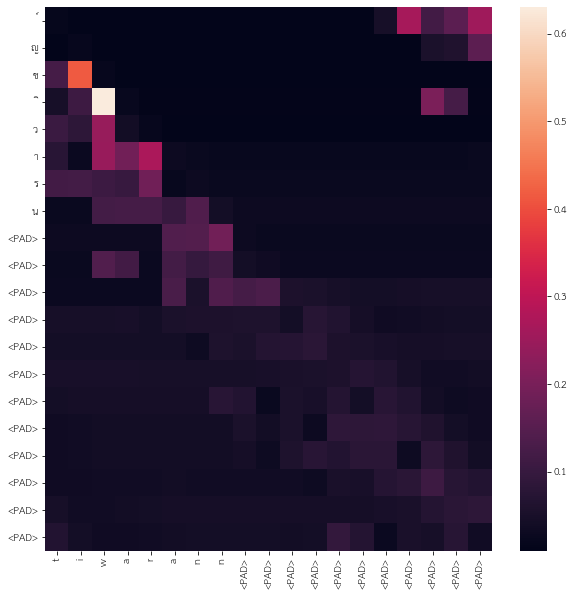

In [98]:
#task 5
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family']='TH Sarabun New'  #you can change to other font that works for you
#fill your code here


english = [ix_to_output_char[np.argmax(each)] for each in y_pred[:,0,:]]
thai = [ix_to_char[each] for each in _X_test[0]]
fig, ax = plt.subplots(figsize=(10,10))  
heatmap = sns.heatmap(
    attention_np[0],
    xticklabels=english[::-1], 
    yticklabels=thai[::-1])

In [74]:
X_test[0].shape

(20, 65)